tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Using device: cuda


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Start Training...
Epoch 1/10, Training Loss: 3661.3585, Validation Loss: 13.6303
Epoch 2/10, Training Loss: 7.7677, Validation Loss: 13.8940
Epoch 3/10, Training Loss: 3.7428, Validation Loss: 14.8874
Epoch 4/10, Training Loss: 2.5811, Validation Loss: 15.0876
Epoch 5/10, Training Loss: 2.2025, Validation Loss: 16.0664
Epoch 6/10, Training Loss: 2.6584, Validation Loss: 17.8014
Epoch 7/10, Training Loss: 4.9966, Validation Loss: 19.4652
Epoch 8/10, Training Loss: 9.9304, Validation Loss: 21.4620
Epoch 9/10, Training Loss: 3.1122, Validation Loss: 22.4353
Epoch 10/10, Training Loss: 4.3039, Validation Loss: 23.1665
Finished Training
Model weights saved successfully!
Ranked Companies:
Rank 1: Idea: Blockchain-based voting platform, Predicted Score: 3.8425


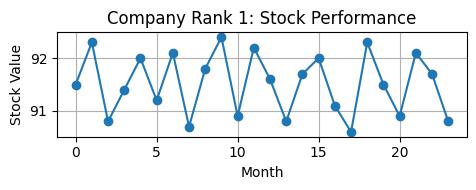

Rank 2: Idea: Revolutionary AI-powered personal assistant, Predicted Score: 3.7010


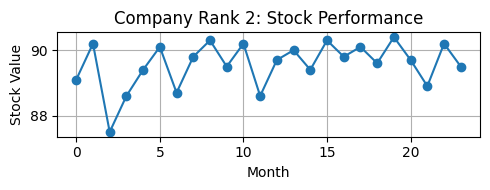

Rank 3: Idea: AI-powered educational tools, Predicted Score: 3.6191


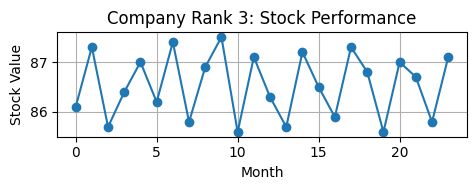

Rank 4: Idea: Smart agriculture technology, Predicted Score: 3.5040


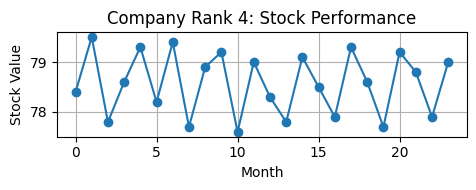

Rank 5: Idea: Next-generation electric vehicles, Predicted Score: 3.4914


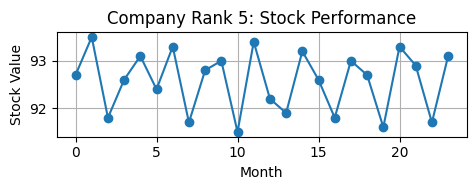

Rank 6: Idea: Sustainable energy solutions for homes, Predicted Score: 3.4536


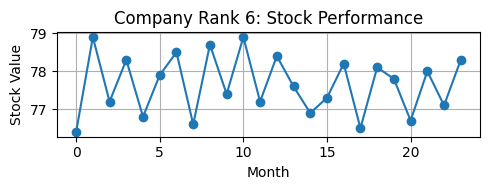

Rank 7: Idea: AI-driven stock market analysis, Predicted Score: 3.4365


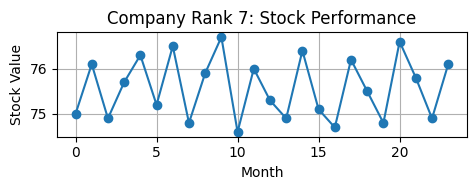

Rank 8: Idea: Virtual reality training simulations, Predicted Score: 3.3059


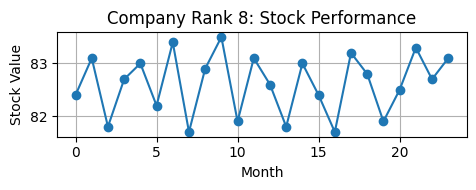

Rank 9: Idea: Personalized health monitoring system, Predicted Score: 3.2547


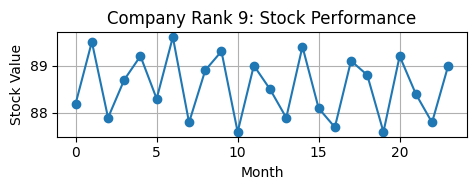

Rank 10: Idea: Automated drone delivery system, Predicted Score: 2.9332


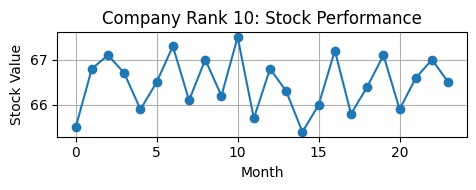

In [1]:
import torch
from torch.utils.data import Dataset
import pandas as pd
from transformers import BertTokenizer, BertModel
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Subset
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

# Dataset class to load and preprocess CSV data
class BusinessIdeaDataset(Dataset):
    def __init__(self, csv_file, tokenizer, max_length=512):
        self.data = pd.read_csv(csv_file)
        self.tokenizer = tokenizer
        self.max_length = max_length

        # Normalize the stock performance columns
        stock_columns = self.data.columns[3:]  # Assuming these are month_1_performance to month_24_performance
        scaler = MinMaxScaler()
        self.data[stock_columns] = scaler.fit_transform(self.data[stock_columns])
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        idea = row['Idea']
        score = row['Score']
        stock_performance = row.iloc[3:].values.astype(float)  # month_1_performance to month_24_performance
        
        # Tokenizing the idea text
        inputs = self.tokenizer.encode_plus(
            idea,
            None,
            add_special_tokens=True,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )
        
        input_ids = inputs['input_ids'].squeeze(0)  # Shape (max_length,)
        attention_mask = inputs['attention_mask'].squeeze(0)  # Shape (max_length,)
        
        return {
            'input_ids': input_ids,
            'attention_mask': attention_mask,
            'stock_performance': torch.tensor(stock_performance, dtype=torch.float),
            'score': torch.tensor(score, dtype=torch.float)
        }

# Model architecture
class RankingModel(nn.Module):
    def __init__(self, bert_model_name='all-MiniLM-L6-v2', hidden_size=256):
        super(RankingModel, self).__init__()
        
        # Text processing using pre-trained BERT
        self.bert = BertModel.from_pretrained(bert_model_name)
        self.bert_drop = nn.Dropout(0.3)
        self.bert_fc = nn.Linear(self.bert.config.hidden_size, hidden_size)
        
        # Stock performance processing using a simple feed-forward layer
        self.stock_fc = nn.Linear(24, hidden_size)
        
        # Final layers to predict the score
        self.fc1 = nn.Linear(hidden_size * 2, hidden_size)
        self.fc2 = nn.Linear(hidden_size, 1)  # Single output (float score)
    
    def forward(self, input_ids, attention_mask, stock_performance):
        # Text embedding using BERT
        text_output = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        text_features = text_output.pooler_output  # (batch_size, hidden_size)
        text_features = self.bert_fc(text_features)
        
        # Process stock performance
        stock_features = self.stock_fc(stock_performance)
        
        # Combine features
        combined_features = torch.cat((text_features, stock_features), dim=1)
        
        # Final layers
        x = torch.relu(self.fc1(combined_features))
        score = self.fc2(x)
        
        return score.squeeze()


# Tokenizer and dataset setup
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', clean_up_tokenization_spaces=False)

# Load the dataset
dataset = BusinessIdeaDataset(csv_file='/kaggle/input/datasetwithstockvalues/final_dataset_stock_values.csv',tokenizer=tokenizer)

# Split indices into training (80%) and evaluation (20%)
train_indices, val_indices = train_test_split(list(range(len(dataset))),test_size=0.2,random_state=42  # For reproducibility
                                             )

# Create subsets for training and validation
train_dataset = Subset(dataset, train_indices)
val_dataset = Subset(dataset, val_indices)

# Create data loaders for training and validation
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Move the model to GPU
model = RankingModel().to(device)

# Optimizer and loss function remain the same
optimizer = optim.Adam(model.parameters(), lr=1e-5)
loss_fn = nn.MSELoss()

# Training loop with GPU support
epochs = 10
print('Start Training...')
for epoch in range(epochs):
    # Training phase
    model.train()
    train_loss = 0.0
    for batch in train_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        stock_performance = batch['stock_performance'].to(device)
        scores = batch['score'].to(device)

        optimizer.zero_grad()
        predicted_scores = model(input_ids, attention_mask, stock_performance)
        predicted_scores = predicted_scores.view(-1, 1)
        scores = scores.view(-1, 1)

        loss = loss_fn(predicted_scores, scores)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    # Validation phase
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for batch in val_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            stock_performance = batch['stock_performance'].to(device)
            scores = batch['score'].to(device)

            predicted_scores = model(input_ids, attention_mask, stock_performance)
            predicted_scores = predicted_scores.view(-1, 1)
            scores = scores.view(-1, 1)

            loss = loss_fn(predicted_scores, scores)
            val_loss += loss.item()

    print(f"Epoch {epoch + 1}/{epochs}, Training Loss: {train_loss / len(train_loader):.4f}, Validation Loss: {val_loss / len(val_loader):.4f}")
print('Finished Training')

# Save the model weights
torch.save(model.state_dict(), "ranking_model_weights.pth")
print("Model weights saved successfully!")


# Example data for ten companies with realistic stock performance
companies = [
    {"idea": "Revolutionary AI-powered personal assistant",
        "stock_performance": [89.1, 90.2, 87.5, 88.6, 89.4, 90.1, 88.7, 89.8, 90.3, 89.5, 90.2, 88.6, 89.7, 90.0, 89.4, 90.3, 89.8, 90.1, 89.6, 90.4, 89.7, 88.9, 90.2, 89.5]},
    {"idea": "Sustainable energy solutions for homes",
        "stock_performance": [76.4, 78.9, 77.2, 78.3, 76.8, 77.9, 78.5, 76.6, 78.7, 77.4, 78.9, 77.2, 78.4, 77.6, 76.9, 77.3, 78.2, 76.5, 78.1, 77.8, 76.7, 78.0, 77.1, 78.3]},
    {"idea": "Automated drone delivery system",
        "stock_performance": [65.5, 66.8, 67.1, 66.7, 65.9, 66.5, 67.3, 66.1, 67.0, 66.2, 67.5, 65.7, 66.8, 66.3, 65.4, 66.0, 67.2, 65.8, 66.4, 67.1, 65.9, 66.6, 67.0, 66.5]},
    {"idea": "Blockchain-based voting platform",
        "stock_performance": [91.5, 92.3, 90.8, 91.4, 92.0, 91.2, 92.1, 90.7, 91.8, 92.4, 90.9, 92.2, 91.6, 90.8, 91.7, 92.0, 91.1, 90.6, 92.3, 91.5, 90.9, 92.1, 91.7, 90.8]},
    {"idea": "Virtual reality training simulations",
        "stock_performance": [82.4, 83.1, 81.8, 82.7, 83.0, 82.2, 83.4, 81.7, 82.9, 83.5, 81.9, 83.1, 82.6, 81.8, 83.0, 82.4, 81.7, 83.2, 82.8, 81.9, 82.5, 83.3, 82.7, 83.1]},
    {"idea": "AI-driven stock market analysis",
        "stock_performance": [75.0, 76.1, 74.9, 75.7, 76.3, 75.2, 76.5, 74.8, 75.9, 76.7, 74.6, 76.0, 75.3, 74.9, 76.4, 75.1, 74.7, 76.2, 75.5, 74.8, 76.6, 75.8, 74.9, 76.1]},
    {"idea": "Personalized health monitoring system",
        "stock_performance": [88.2, 89.5, 87.9, 88.7, 89.2, 88.3, 89.6, 87.8, 88.9, 89.3, 87.6, 89.0, 88.5, 87.9, 89.4, 88.1, 87.7, 89.1, 88.8, 87.6, 89.2, 88.4, 87.8, 89.0]},
    {"idea": "Next-generation electric vehicles",
        "stock_performance": [92.7, 93.5, 91.8, 92.6, 93.1, 92.4, 93.3, 91.7, 92.8, 93.0, 91.5, 93.4, 92.2, 91.9, 93.2, 92.6, 91.8, 93.0, 92.7, 91.6, 93.3, 92.9, 91.7, 93.1]},
    {"idea": "AI-powered educational tools",
        "stock_performance": [86.1, 87.3, 85.7, 86.4, 87.0, 86.2, 87.4, 85.8, 86.9, 87.5, 85.6, 87.1, 86.3, 85.7, 87.2, 86.5, 85.9, 87.3, 86.8, 85.6, 87.0, 86.7, 85.8, 87.1]},
    {"idea": "Smart agriculture technology",
        "stock_performance": [78.4, 79.5, 77.8, 78.6, 79.3, 78.2, 79.4, 77.7, 78.9, 79.2, 77.6, 79.0, 78.3, 77.8, 79.1, 78.5, 77.9, 79.3, 78.6, 77.7, 79.2, 78.8, 77.9, 79.0]}
]

# Load the trained model
#model = RankingModel().to(device)
#model.load_state_dict(torch.load("ranking_model_weights.pth"))
model.eval()

# Load the tokenizer
tokenizer = BertTokenizer.from_pretrained('all-MiniLM-L6-v2', clean_up_tokenization_spaces=False)

# Predict scores
predicted_scores = []
for company in companies:
    idea = company['idea']
    stock_performance = torch.tensor(company['stock_performance'], dtype=torch.float).unsqueeze(0).to(device)

    # Tokenize the idea
    inputs = tokenizer.encode_plus(
        idea,
        None,
        add_special_tokens=True,
        max_length=512,
        padding='max_length',
        truncation=True,
        return_tensors='pt'
    )
    
    input_ids = inputs['input_ids'].to(device)
    attention_mask = inputs['attention_mask'].to(device)

    # Predict score
    with torch.no_grad():
        score = model(input_ids=input_ids, attention_mask=attention_mask, stock_performance=stock_performance)
    predicted_scores.append({"idea": idea, "score": score.item(), "stock_performance": company['stock_performance']})

# Sort the companies by score in descending order
sorted_companies = sorted(predicted_scores, key=lambda x: x['score'], reverse=True)

# Print the results
print("Ranked Companies:")
for rank, company in enumerate(sorted_companies, start=1):
    print(f"Rank {rank}: Idea: {company['idea']}, Predicted Score: {company['score']:.4f}")
    # Plot stock performance
    plt.figure(figsize=(5, 2))
    plt.plot(company['stock_performance'], marker='o', label=f"Stock Performance (Rank {rank})")
    plt.title(f"Company Rank {rank}: Stock Performance")
    plt.xlabel("Month")
    plt.ylabel("Stock Value")
    plt.grid(True)
    plt.tight_layout()
    plt.show()